In [1]:
from matplotlib import pyplot as plt
import imageio
import numpy as np

# grab a couple of image stills

still1 = 255-imageio.imread("data/still1.png")[:,:,0]
still2 = 255-imageio.imread("data/still2.png")[:,:,0]

# Triangulating points from images

## Theory

We're curious about the world-fixed position of the point, given positions of that point projected into a series of images.

Given the point in world coordinatres $\vec{a}$ and camera position in world coordinates $\vec{c}$, the point in camera coordinates $\vec{d}$ is

$$\vec{d} = \vec{a}-\vec{c}$$

The position on the screen is:

$$x = f\frac{d_x}{d_z}$$
$$y = f\frac{d_y}{d_z}$$



which expands to

$$x = f\frac{a_x-c_x}{a_z-c_z}$$
$$y = f\frac{a_y-c_y}{a_z-c_z}$$

We can work this into the form of a matrix

$$- fa_x + 0a_y + xa_z= xc_z - fc_x$$
$$0a_x - fa_y + ya_z= yc_z - fc_y$$

$$
\begin{bmatrix}
    - f       & 0 & x  \\
    0       & -f & y  \\
\end{bmatrix} \vec{a} = 
\begin{bmatrix}
    xc_z - fc_x  \\
    yc_z - fc_y \\
\end{bmatrix}
$$

For multiple camera/observation pairs just stack the matrices:

$$
\begin{bmatrix}
    - f       & 0 & x_1  \\
    0       & -f & y_1  \\
    - f       & 0 & x_2  \\
    0       & -f & y_2  \\
\end{bmatrix} \vec{a} = 
\begin{bmatrix}
    x_1c_{z1} - fc_{x1}  \\
    y_1c_{z1} - fc_{y1} \\
    x_2c_{z2} - fc_{x2}  \\
    y_2c_{z2} - fc_{y2} \\
\end{bmatrix}
$$

Thus we find outselves in familiar territory. We have an equation:

$$A\vec{a} = \vec{v}$$

where

$$ A = \begin{bmatrix}
    - f       & 0 & x_1  \\
    0       & -f & y_1  \\
    - f       & 0 & x_2  \\
    0       & -f & y_2  \\
\end{bmatrix} $$

and

$$\vec{v} = \begin{bmatrix}
    x_1c_{z1} - fc_{x1}  \\
    y_1c_{z1} - fc_{y1} \\
    x_2c_{z2} - fc_{x2}  \\
    y_2c_{z2} - fc_{y2} \\
\end{bmatrix} $$

The solution to $\vec{a}$ is:

$$\vec{a} = A^{-1}\vec{v}$$

Our task then is to construct $A$ from the focal length, camera coordinates, and screen coordinates of our points, and hope that $A$ is invertable.

## Task: find the spire on Market

Let's use this fancy math to find the position of a particular spire present in the 1906 "A Trip Down Market". In the first image, taken at Market and 3rd, it's at pixel (-32, -53) from the center of the image.

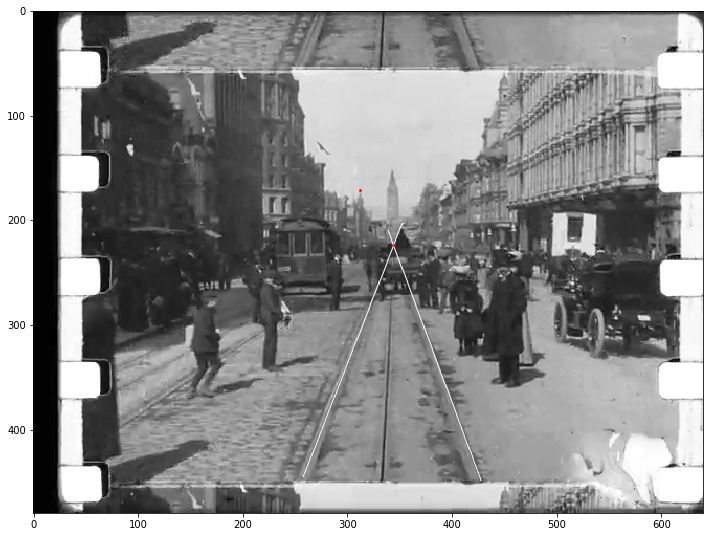

In [2]:
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow( still1, cmap="Greys" )

origin1 = np.array( [344, 224] )
pt1 = np.array( [-32,-53] )
ax.scatter( *origin1, s=3, c="red"  )
ax.scatter( *(origin1+pt1), s=3, c="red"  )

In the second image, taken at 1st and Market, the spire is at (-94, -144) pixels from the image origin.

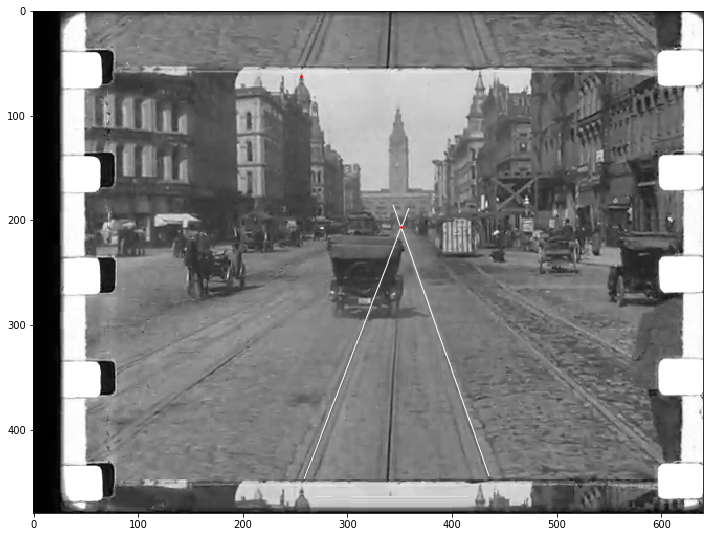

In [3]:
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow( still2, cmap="Greys" )

origin2 = np.array( [351, 206] )
pt2 = np.array( [-95,-144] )
ax.scatter( *origin2, s=3, c="red"  )
ax.scatter( *(origin2+pt2), s=3, c="red"  )

Our question is: where is that spire? To do that we need to find:

* The focal length
* The camera positions in world-space
* The spire locations in image space

## Define the coordinate system

* +x to the right
* +y down
* +z along market towards the ferry building

(0,0,0) is on the ground at 3rd and Market.

This is a convenient coodinate system, because:

* x and y share axes of the images (+x to the right, +y down).
* All camera coordinates in world-space are along the z axis.
* The camera coordinates of the first image are at the origin.
* The coordinate space is orthogonal and obeys the right hand rule.

## Find the focal length

The clock tower at the ferry building has a 6.7 meter-wide clock face. From the intersection of Beale and Market 469 meters away, the clock sweeps out:

$$ \arctan( 6.7 / 459 ) = 0.89 \deg $$

In the frame taken at Beale and Market, the clock tower is 17 pixels wide. Thus the angular resolution of the image is:

$$ \frac{0.89 \deg}{17 pixels} \approx 0.048 \deg / pixels$$

The frame is 570 pixels wide. Thus the entire frame is $570 pixels \cdot 0.048 \deg/pixels = 27.4 \deg$

This translates to a focal length $f$ of 2.05; or (in this case) $570 pixels\cdot2.05 = 1168.5 pixels$.

In [4]:
f = 1168.5

## Find the camera coordinates

The first camera position is (by our own previous definition) at (0,0,0).

In [5]:
c1 = np.array( (0,0,0) )

The second camera position is almost exactly 500 meters away, directly down market. Since we defined +z as "down market", the second camera coordinate is simply (0,0,500).

In [6]:
c2 = np.array( (0,0,500) )

## Find image coordinates

By inspection the first image coordinate is:

In [7]:
pt1

array([-32, -53])

And the second is:

In [8]:
pt2

array([ -95, -144])

## Put it all together

We have all the pieces to build up $A$ and $\vec{v}$.

In [19]:
x1, y1 = pt1
x2, y2 = pt2
cx1, cy1, cz1 = c1
cx2, cy2, cz2 = c2

A = np.array([[-f, 0, x1],
              [0, -f, y1],
              [-f, 0, x2],
              [0, -f, y2]])

v = np.array([[x1*cz1 - f*cx1],
              [y1*cz1 - f*cy1],
              [x2*cz2 - f*cx2],
              [y2*cz2 - f*cy2]])

Ainv = np.linalg.pinv(A) #use pseudo-inverse, because the matrix is not square
ahat = Ainv.dot(v)
ahat = ahat.T[0] #convert from column matrix to vector
ahat

array([-22.01589339, -34.86997983, 779.14285714])

Now that we have a guess about the world coordinates of the spire. If it were true, what would the pixel coordinates be in each image?

In [20]:
dhat = ahat - np.stack([c1, c2])
dhat

array([[-22.01589339, -34.86997983, 779.14285714],
       [-22.01589339, -34.86997983, 279.14285714]])

In [21]:
xhat = f*(dhat[:,0] / dhat[:,2])
yhat = f*(dhat[:,1] / dhat[:,2])

In [22]:
screenhat = np.stack( [xhat, yhat] ).T

In [24]:
screenhat - np.stack([pt1, pt2])

array([[-1.01778511,  0.70462046],
       [ 2.8408393 , -1.9667349 ]])

The first prediction is off by -1 pixel horizontally and 0.7 pixels vertically. The second is off by 2.8 pixels horizontally and -1.9 pixels vertically. Pretty good!

So, the spire was 780 meters down-track from 3rd and Market, 22 meters to the left and 34 meters tall.

This is the corner of Beale and Market. The half-width of the right-of-way is about 22 meters, and 34.8 meters (117 feet) seems reasonable for the height of the spire.